## Loading data

In [1]:
from freqtrade.data.btanalysis import load_trades_from_db
import plotly.figure_factory as ff
import plotly.express as px
import pandas as pd
import numpy as np

# Fetch trades from database
tradesA = load_trades_from_db("sqlite:///../db/equeum.futures.dry.sqlite")
closed_tradesA = tradesA[tradesA['is_open'] == False]


# Profit reason counts

In [2]:
# Display results
exit_reasonsA = closed_tradesA.groupby("pair")["exit_reason"]

exit_reasonsA.value_counts()


pair        exit_reason
ADA/USDT    exit_signal    1
AUDIO/USDT  exit_signal    1
BNB/USDT    exit_signal    1
CHZ/USDT    exit_signal    1
COMP/USDT   exit_signal    1
EOS/USDT    exit_signal    1
ETH/USDT    exit_signal    1
HOT/USDT    exit_signal    1
ICP/USDT    exit_signal    1
SOL/USDT    exit_signal    1
Name: exit_reason, dtype: int64

<AxesSubplot:ylabel='exit_reason'>

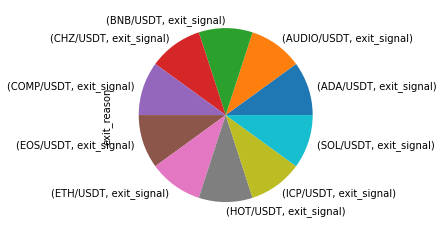

In [3]:
exit_reasonsA.apply(pd.value_counts).plot.pie(subplots=False)

## Plot average profit per trade as distribution graph

### VarA

In [4]:
hist_data = [closed_tradesA.profit_ratio]
group_labels = ['profit_ratio']  # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=0.01)
fig.show()


In [5]:
fig = px.box(closed_tradesA, x=group_labels)
fig.show()

# Kelly Ratio

In [6]:
from tabulate import tabulate

def pair_kelly(trades):
	pairs = trades.groupby('pair').groups.keys()
	results = []
	for pair in pairs:
		pair_trades = trades[trades['pair'] == pair]

		win_trades = pair_trades[pair_trades['profit_ratio'] > 0]
		loss_trades = pair_trades[pair_trades['profit_ratio'] < 0]

		W = win_trades.shape[0] / pair_trades.shape[0]
		R = win_trades['profit_abs'].mean() / loss_trades['profit_abs'].abs().mean()

		K = W - ((1 - W) / R)

		stoploss = 0.03
		growth_leverage = K / stoploss

		results.append({
			"pair": pair,
			"trades": pair_trades.shape[0],
			"win_probability": W*100,
			"profit/loss": f"{win_trades['profit_abs'].mean():.2f}/{loss_trades['profit_abs'].mean():.2f}",
			"profit_ratio": R,
			"max_win": win_trades['profit_abs'].max(),
			"max_loss": loss_trades['profit_abs'].min(),
			"kelly": K,
			"leverage(1)": growth_leverage,
			"leverage(0.75)": growth_leverage * 0.75,
			"leverage(0.5)": growth_leverage * 0.5,
			"leverage(0.33)": growth_leverage * 0.33,
			"leverage(0.25)": growth_leverage * 0.25
		})
	
	print(tabulate(sorted(results, key=lambda x: x["kelly"], reverse=True), headers="keys"))
	

def kelly_criterion(trades):
	profit_trades = trades[trades['profit_ratio'] > 0]
	lose_trades = trades[trades['profit_ratio'] < 0]
	W = profit_trades.shape[0] / trades.shape[0]
	print('====================================================')
	print(f'Total trades = {trades.shape[0]}')
	print(f'Wins / Losses = {profit_trades.shape[0]} / {lose_trades.shape[0]}')
	print(f'Win probability = {(W*100):.2f}%')

	total_profit = profit_trades['profit_abs'].sum()
	avg_profit = profit_trades['profit_abs'].mean()
	avg_profit_ratio = profit_trades['profit_ratio'].mean()
	avg_profit_std = profit_trades['profit_abs'].std()
	profit_ratio_std = profit_trades['profit_ratio'].std()
	print('====================================================')
	print(f'Total profit = ${total_profit:.2f}')
	print(f'Avg profit = ${avg_profit:.2f}')
	print(f'Avg profit % = {(avg_profit_ratio*100):.2f}%')
	print(f'Profit stdev = {avg_profit_std:.2f}')
	print(f'Profit ratio stdev = {profit_ratio_std:.2f}%')

	total_loss = lose_trades['profit_abs'].abs().sum()
	avg_loss = lose_trades['profit_abs'].abs().mean()
	avg_loss_ratio = lose_trades['profit_ratio'].abs().mean()
	print('====================================================')
	print(f'Total loss = ${total_loss:.2f}')
	print(f'Avg loss = ${avg_loss:.2f}')
	print(f'Avg loss % = {(avg_loss_ratio*100):.2f}%')
	print('====================================================')
	R = total_profit / total_loss
	print(f'Profit Factor = {R:.2f}')

	R2 = avg_profit / avg_loss
	print(f'Avg win/loss ratio = {R2:.4f}')

	# Kelly = W - ((1-W)/R)
	# print(f'Kelly Criterion = {Kelly:.4f}')

	K = W - ((1 - W) / R2)
	print(f'Kelly Criterion = {K:.4f}')

	stoploss = 0.03
	growth_leverage = K / stoploss

	print(f'Best leverage (0.25, 0.5, 0.75) = {growth_leverage*0.25:.4f}, {growth_leverage*0.5:.4f}, {growth_leverage*0.75:.4f}')
	
	# F = W - (1 - W)/(avg_profit - 1)
	# print(f'F (ideal bet size) = {F:.4f}')

	# advanced kelly criterion and ideal leverage size
	# kelly_adv = (avg_profit) / avg_profit_std**2

	# print(f'Advanced Kelly = {kelly_adv:.4f}')
	print('====================================================')




## VarA

In [7]:
kelly_criterion(closed_tradesA)

Total trades = 10
Wins / Losses = 0 / 10
Win probability = 0.00%
Total profit = $0.00
Avg profit = $nan
Avg profit % = nan%
Profit stdev = nan
Profit ratio stdev = nan%
Total loss = $1.40
Avg loss = $0.14
Avg loss % = 0.37%
Profit Factor = 0.00
Avg win/loss ratio = nan
Kelly Criterion = nan
Best leverage (0.25, 0.5, 0.75) = nan, nan, nan


In [8]:
pair_kelly(closed_tradesA)

pair          trades    win_probability  profit/loss      profit_ratio    max_win    max_loss    kelly    leverage(1)    leverage(0.75)    leverage(0.5)    leverage(0.33)    leverage(0.25)
----------  --------  -----------------  -------------  --------------  ---------  ----------  -------  -------------  ----------------  ---------------  ----------------  ----------------
ADA/USDT           1                  0  nan/-0.22                 nan        nan  -0.22494        nan            nan               nan              nan               nan               nan
AUDIO/USDT         1                  0  nan/-0.09                 nan        nan  -0.0867376      nan            nan               nan              nan               nan               nan
BNB/USDT           1                  0  nan/-0.07                 nan        nan  -0.0695687      nan            nan               nan              nan               nan               nan
CHZ/USDT           1                  0  nan/-0.08     